In [1]:
import os
import pandas as pd
import pdb
import time
from sklearn.preprocessing import minmax_scale

def blend(path, select_to_essemble, weights=None, minmaxscale=False, shortenname=False):
    if weights is not None:
        if type(weights) != dict:
            raise ValueError('weights must be a dict or None')
        sum_weight = sum(weights.values())
        if int(sum_weight*10000)+1 != 10000 and int(sum_weight) != 1: # sometimes sum can be 0.9999999999999999, which is 1 essentially
            raise ValueError('sum of weights must be 1, but you have: {}'.format(sum_weight))
        if len(select_to_essemble) != len(weights):
            raise ValueError('when weight is not None, it must have length of select_to_essemble')
    xgb_topn_repo = {}   
    cnt = 0
    for filename in os.listdir(path):
#         pdb.set_trace()
        #score += float(item.split('_')[-1])
        select = None
        if len(select_to_essemble) == 0: # if selecting any specific ones to essemble, then essemble all 
            select = filename
        else:
            if filename in select_to_essemble:
                select = filename
            else:
                continue
        print('selected: ' + select)
        tmp = pd.read_csv(path+select)
        if shortenname:
            if select.split('.')[-1] == 'gz':
                shortened_name = select.split('.')[-3].split('_')[-1]
            else:
                shortened_name = select.split('.')[-2].split('_')[-1]
            xgb_topn_repo[shortened_name] = tmp.copy()
        else:
            xgb_topn_repo[select] = tmp.copy()
#         import pdb
#         pdb.set_trace()
        if cnt == 0:
            label_cols = list(tmp.columns)
            label_cols.pop(0) # remove 'id'
            print('please check if the label_cols is right:')
            print(label_cols)
        if minmaxscale:
            tmp[label_cols] = minmax_scale(tmp[label_cols].values)  
        if weights is not None:
            tmp[label_cols] = tmp[label_cols].applymap(lambda x: x*weights[select])
        if cnt == 0:
            preds = tmp
        else:
            preds[label_cols] += tmp[label_cols]  
        cnt += 1

    print(str(cnt)+' results selected')
    if weights is None:
        preds[label_cols] = preds[label_cols].applymap(lambda x: x/cnt)
    return preds, label_cols, xgb_topn_repo, cnt

path = '/home/kai/data/kaggle/talkingdata/data/SUBS/'#'NewRnnPreds/'

select_to_essemble = []
for filename in os.listdir(path):
    if 'csv' in filename:
        select_to_essemble.append(filename)
        print(filename)

select_to_essemble

preds, label_cols, xgb_topn_repo, cnt = blend(path, select_to_essemble)

In [2]:
path = '/home/kai/data/kaggle/talkingdata/data/SUBS/'

select_to_essemble = [
    #'equal_hour_blend_matrixregV5_leaf61_firsttimediff_exclude_lb0.9800.csv.gz',
    'allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz',
    'equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz'
    #'sub_it_4513683_9778.csv.gz',
    #'wordbatch_fm_ftrl_4525246_9769.csv.gz'
]

weights = {
    'allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz':0.6,
    'equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz':0.4
#     'equal_hour_blend_matrixregV5_leaf61_firsttimediff_exclude_lb0.9800.csv.gz':0.7,
#     'sub_it_4513683_9778.csv.gz':0.3,
    #'wordbatch_fm_ftrl_4525246_9769.csv.gz':0.2
}

preds, label_cols, xgb_topn_repo, cnt = blend(path, select_to_essemble, weights)

selected: allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz
please check if the label_cols is right:
['is_attributed']
selected: equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz
2 results selected


In [3]:
preds.head(3)

,click_id,is_attributed
0,0,0.188898
1,1,0.031069
2,2,0.003919


In [4]:
list(xgb_topn_repo)

['allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz',
 'equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz']

In [5]:
import sys
sys.path.append('/home/kai/data/shiyi/Kaggle/toxic/sc/stacking')
from toxic_utils import scatter_per_label
import matplotlib.pyplot as plt
%matplotlib inline

is_attributed
['allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz', 'equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz']


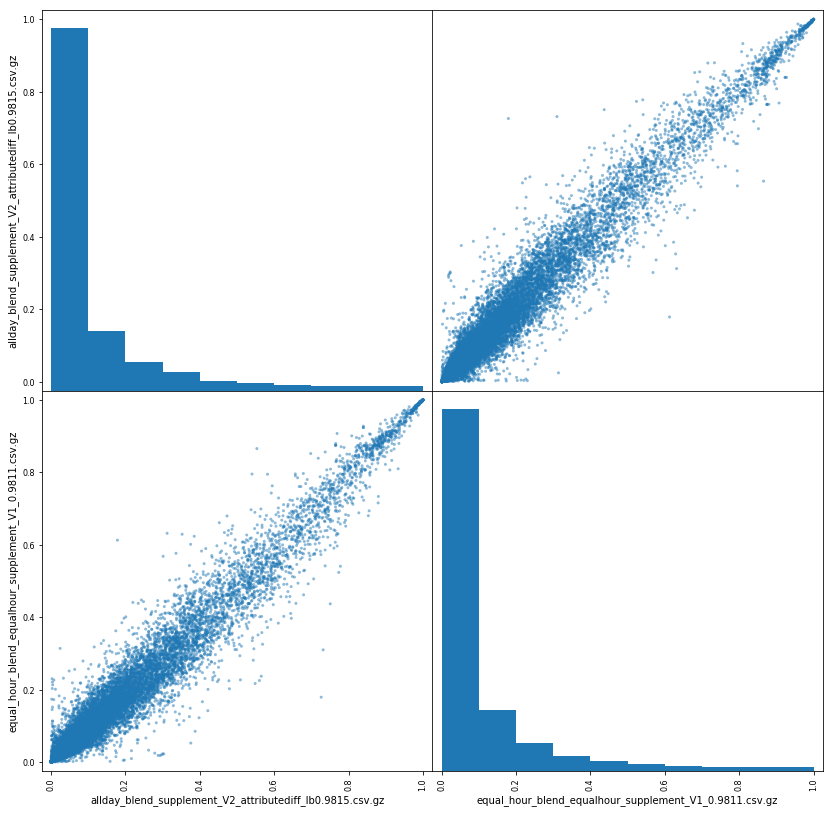

In [6]:
scatter_per_label(xgb_topn_repo, 'is_attributed', 30000)

In [7]:
list(xgb_topn_repo)

['allday_blend_supplement_V2_attributediff_lb0.9815.csv.gz',
 'equal_hour_blend_equalhour_supplement_V1_0.9811.csv.gz']

In [8]:
tempid = ''
for selected in select_to_essemble:
    temp = selected.split('_')[-1].split('.')[0]
    if len(temp) > 7:
        temp = temp[3:]
    print(temp)
    tempid += temp + '_'
print(tempid)

lb0
0
lb0_0_


In [9]:
essemble_name = 'Blend64_lb9815_9811' 
tempid = str(int(time.time()))[3:]
print(tempid) 
preds.to_csv(path+essemble_name+'_{}_{}.csv.gz'.format(cnt, tempid), index=False, float_format='%.9f', compression='gzip')

5042835


In [10]:
preds.tail()

,click_id,is_attributed
18790464,18790464,0.450775
18790465,18790465,0.001221
18790466,18790467,0.059170
18790467,18790466,0.063150
18790468,18790468,0.014700


In [14]:
sub1.tail()

,click_id,is_attributed
18790464,18790464,0.271267
18790465,18790465,0.000226
18790466,18790467,0.013739
18790467,18790466,0.035154
18790468,18790468,0.015491
